# マルチリンク機構のクラス

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, Image

class Link:
    "1リンク分のクラス"
    def __init__(self, length=1.0, angle=0.0):
        self.length = length
        self.angle = angle

    def set_angle(self, angle):
        self.angle = angle

    def get_end_position(self, start_pos, start_angle):
        total_angle = start_angle + self.angle
        x = start_pos[0] + self.length * np.cos(total_angle)
        y = start_pos[1] + self.length * np.sin(total_angle)
        return (x, y), total_angle

class Manipulator:
    "3リンク繋いだクラス"
    def __init__(self):
        self.links = [Link(length=3.0, angle=0.0), Link(length=2.0, angle=0.0), Link(length=1.0, angle=0.0)]

    def set_angles(self, angles):
        for link, angle in zip(self.links, angles):
            link.set_angle(angle)

    def get_joint_positions(self):
        positions = [[0, 0]]  # Start at origin
        total_angle = 0.0
        for link in self.links:
            pos, total_angle = link.get_end_position(positions[-1], total_angle)
            positions.append(pos)
        return positions

    def evaluate_movement(self, angular_velocities, target_object, filename='three_link_animation.gif', threshold=0.2):
        if np.max(np.array(angular_velocities)[:,0]) > 0.1:
            return "link1 velocity error", -1

        if np.max(np.array(angular_velocities)[:,1]) > 0.2:
            return "link2 velocity error", -1

        if np.max(np.array(angular_velocities)[:,2]) > 0.5:
            return "link3 velocity error", -1

        fig, ax = plt.subplots()
        ax.set_aspect('equal', 'box')
        ax.grid(True, which='both')
        max_length = sum([link.length for link in self.links])
        ax.set_xlim(-max_length, max_length)
        ax.set_ylim(-max_length, max_length)

        # 初期角度を0に設定
        current_angles = np.array([link.angle for link in self.links])

        # 初期の関節位置
        positions = self.get_joint_positions()
        (line,) = ax.plot(
            [pos[0] for pos in positions],
            [pos[1] for pos in positions],
            'o-', lw=2
        )

        # ターゲットオブジェクトをプロット
        target_plot, = ax.plot(
            [obj[0] for obj in target_object],
            [obj[1] for obj in target_object],
            'ro', lw=2
        )

        # 残りのターゲットオブジェクトを管理
        remaining_objects = target_object.copy()
        steps_to_grab_all = -1

        # 接触チェック
        def check_collision(positions, objects, threshold):
            positions = np.array(positions)
            objects = np.array(objects)
            distances = np.linalg.norm(positions[:, np.newaxis] - objects.T, axis=0)
            grabbed_objects = objects[distances <= threshold].tolist()
            return grabbed_objects

        # アニメーション描画
        def init():
            pass

        def update(i):
            nonlocal steps_to_grab_all
            nonlocal current_angles

            # 角度を設定し、アームの関節位置を更新
            self.set_angles(current_angles)

            # 位置を更新
            positions = self.get_joint_positions()
            line.set_data(
                [pos[0] for pos in positions],
                [pos[1] for pos in positions]
            )

            # オブジェクトが掴まれたかどうかチェック
            grabbed_objects = check_collision(positions[-1], remaining_objects, threshold)
            for obj in grabbed_objects:
                remaining_objects.remove(obj)

            # 残っているオブジェクトのプロットを更新
            target_plot.set_data(
                [obj[0] for obj in remaining_objects],
                [obj[1] for obj in remaining_objects]
            )

            # 全てのオブジェクトを掴んだときのステップ数を記録
            if len(remaining_objects) == 0 and steps_to_grab_all == -1:
                steps_to_grab_all = i

            # 角速度 => 角度
            if len(angular_velocities) > i:
              current_angles += np.array(angular_velocities[i])

            return line, target_plot

        # アニメーションの設定
        ani = FuncAnimation(fig, update, init_func=init, frames=len(angular_velocities)+1, interval=50)

        # GIFとして保存
        ani.save(filename, writer='pillow', fps=30)
        plt.close(fig)

        # すべてのオブジェクトを掴んだかを判定
        if not remaining_objects:
            return "Success", steps_to_grab_all
        else:
            return "Fail", steps_to_grab_all


# 問題

In [ ]:
def generate_objects_polar(num_objects, max_radius=6):
    radii = np.random.rand(num_objects) * max_radius
    angles = np.random.rand(num_objects) * 2 * np.pi
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return [[x[i], y[i]] for i in range(num_objects)]

# ターゲットオブジェクトを乱数で生成
target_object_list = []
target_object_list.append([[-6,0],[-5,0],[-3,0],[-1,0]])
target_object_list.append([[-6,0],[ 0,6],[5,0],[0,-4]])

# 乱数問題
np.random.seed(1)
for _ in range(8):
    num_objects = 4
    objects = generate_objects_polar(num_objects)
    target_object_list.append(objects)


# 以下書き換えOK

problem:  0 , status:  Success , num steps:  62


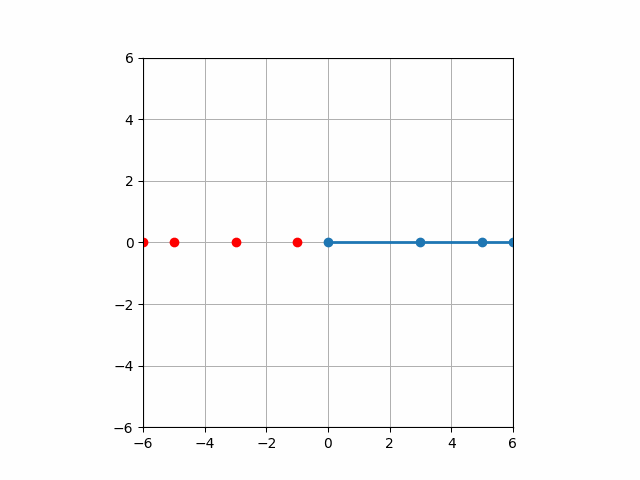

problem:  1 , status:  Success , num steps:  89


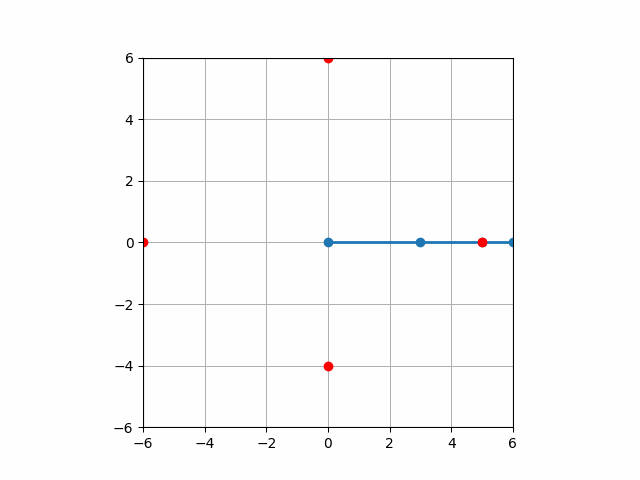

problem:  2 , status:  Success , num steps:  61


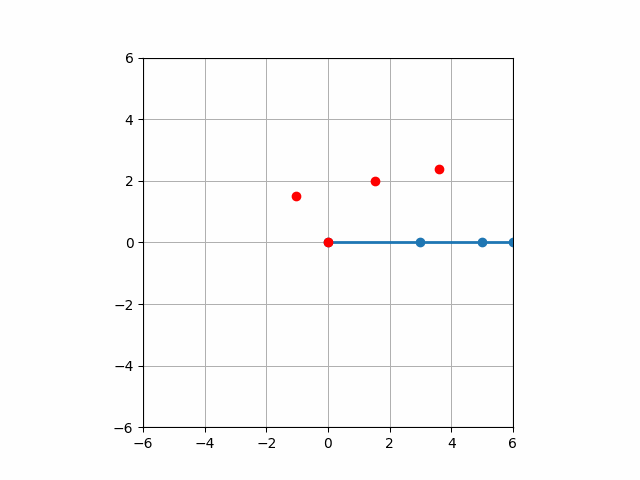

problem:  3 , status:  Success , num steps:  72


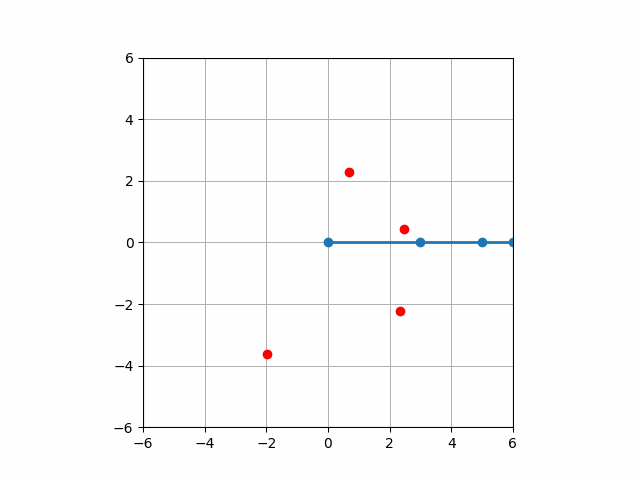

problem:  4 , status:  Success , num steps:  79


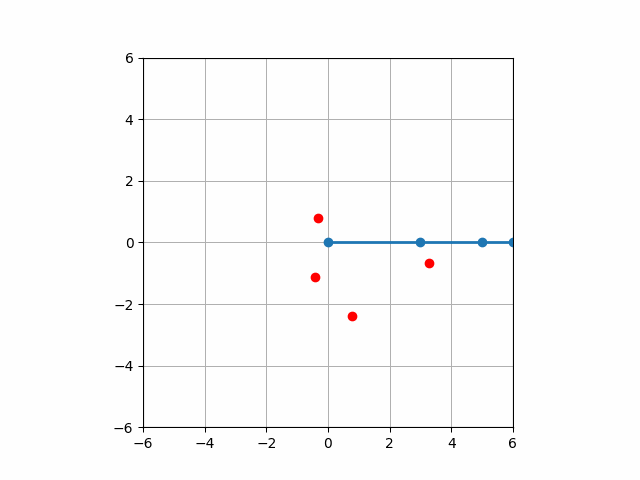

problem:  5 , status:  Success , num steps:  64


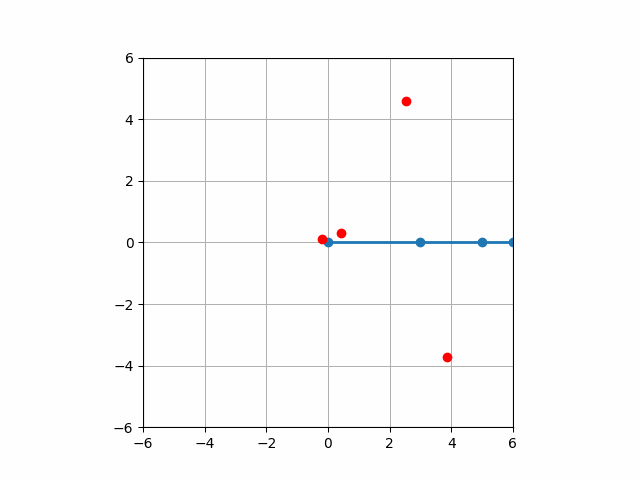

problem:  6 , status:  Success , num steps:  73


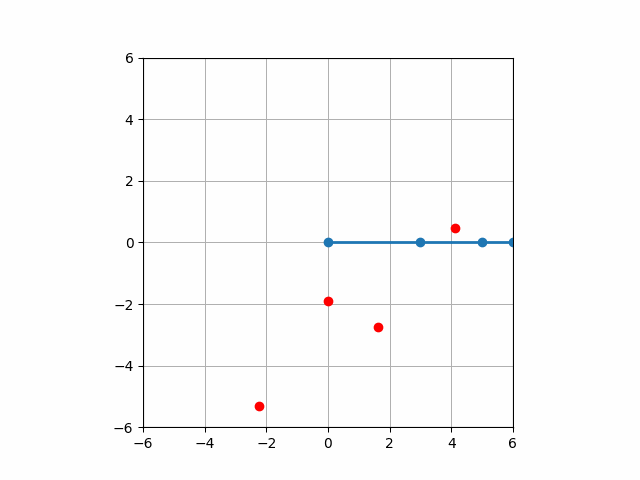

problem:  7 , status:  Success , num steps:  76


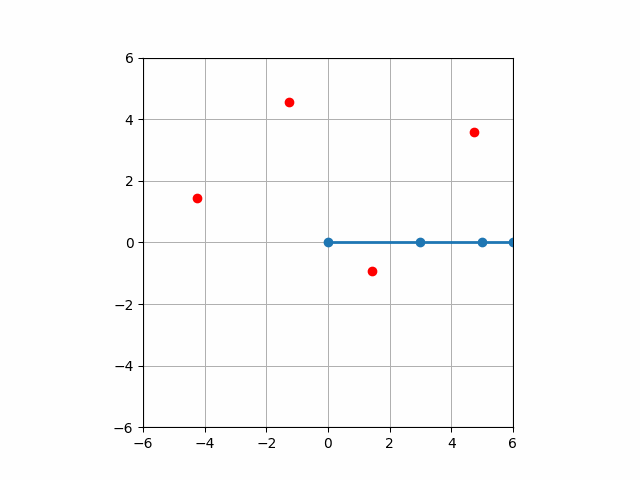

problem:  8 , status:  Success , num steps:  65


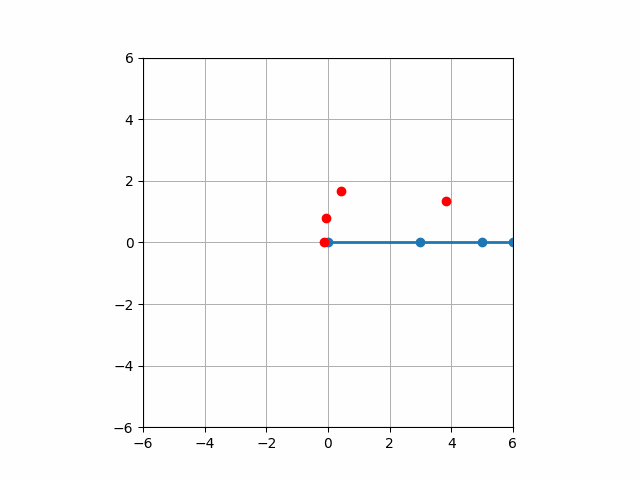

problem:  9 , status:  Success , num steps:  75


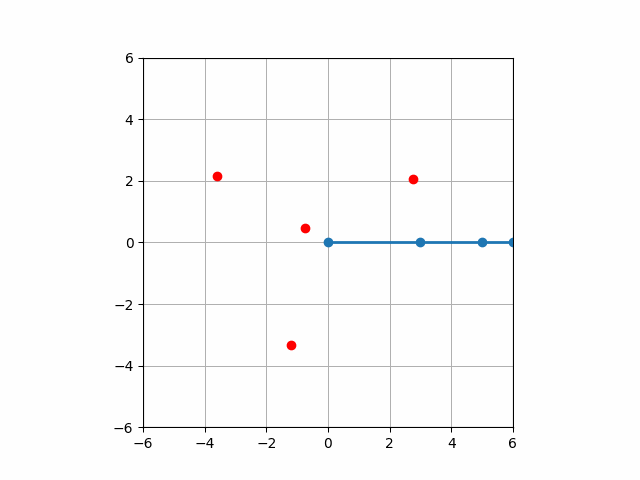

In [ ]:
def make_plan(target_object):
    # プランを初期化
    angular_velocities = []

    # 現在の角度を取得
    current_angles = np.array([0.0, 0.0])
    max_velocity = 0.1

    # L2, L3は一体と考える
    link_lengths = [3.0, 3.0]

    # ターゲット位置に到達するためのIKの計算
    def inverse_kinematics(target_pos, link_lengths):
        L1, L2 = link_lengths
        x, y = target_pos

        # 目標の距離を計算
        r = np.hypot(x, y)

        # 余弦定理でtheta2を求める
        cos_theta2 = (r**2 - L1**2 - L2**2) / (2 * L1 * L2)
        theta2 = np.arccos(cos_theta2)

        # theta1を計算
        theta1 = np.arctan2(y, x) - np.arctan2(L2 * np.sin(theta2), L1 + L2 * np.cos(theta2))

        return np.array([theta1, theta2])

    for obj in target_object:
        x, y = obj
        r = np.hypot(x, y)

        # 到達可能かチェック
        if r > (link_lengths[0] + link_lengths[1]):
          return None  #ここには来ない

        # 目標角度を計算
        target_angles = inverse_kinematics(obj, link_lengths)

        # 現在の角度との差分を計算
        angle_diffs = target_angles - current_angles
        angle_diffs = (angle_diffs + np.pi) % (2 * np.pi) - np.pi  # 正規化

        # 必要なステップ数を計算
        steps = int(np.ceil(np.max(np.abs(angle_diffs)) / max_velocity))
        if steps == 0:
            steps = 1

        # 各関節の角速度を計算
        velocities = angle_diffs / steps
        # 各ステップで角速度を追加
        for _ in range(steps):
            angular_velocities.append(np.r_[velocities, 0.0].tolist())
            current_angles += velocities

    return angular_velocities

for i, target_object in enumerate(target_object_list):
    # リンク位置初期化
    # Create a manipulator by connecting the links
    manipulator = Manipulator()
    manipulator.set_angles([0.0, 0.0, 0.0])

    # プラン生成
    target_velocity = make_plan(target_object)
    # 評価
    status, steps = manipulator.evaluate_movement(target_velocity, target_object, filename=f'three_link_animation_{i}.gif')
    print("problem: ", i, ", status: ", status, ", num steps: ", steps)

    if status == "velocity error":
        continue

    # 描画
    display(Image(filename=f'three_link_animation_{i}.gif'))
